In [1]:
%pylab inline
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 12, 10
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_excel('нефть-brent 2010-2019.xlsx', index_col=[0], parse_dates=[0])
data.head()

,Value
Datetime,
2019-09-01,58.84
2019-08-30,59.19
2019-08-29,60.37
2019-08-28,59.84
2019-08-27,59.59


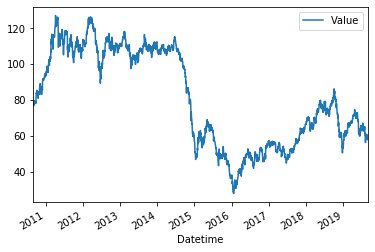

In [3]:
data.plot()

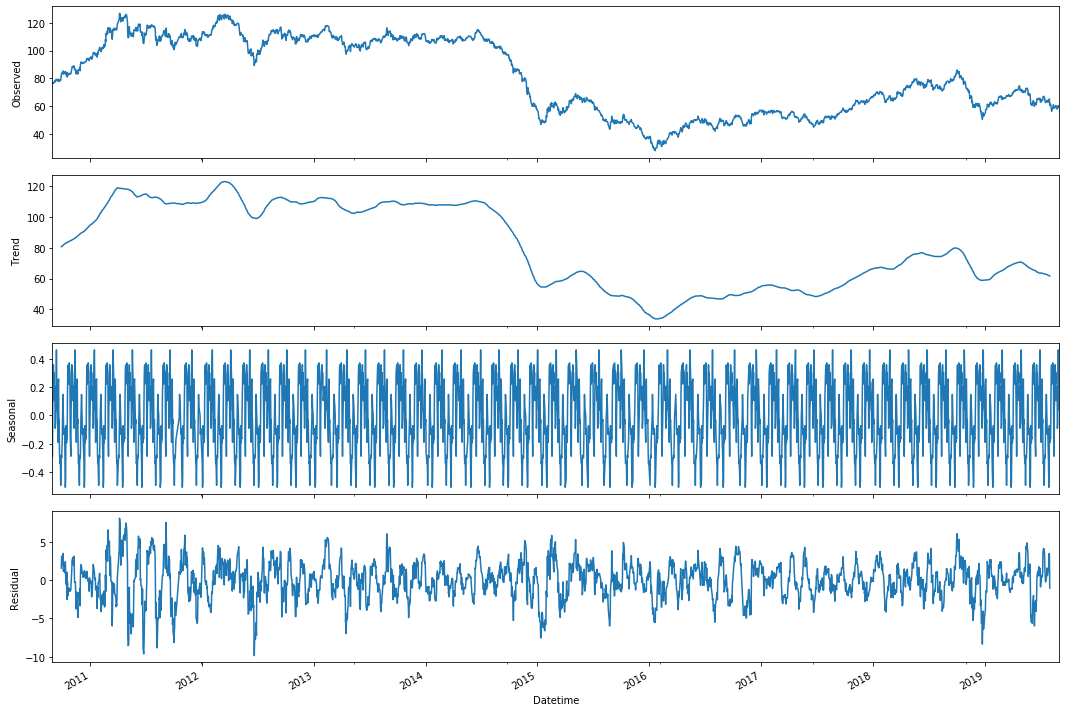

<Figure size 1080x720 with 0 Axes>

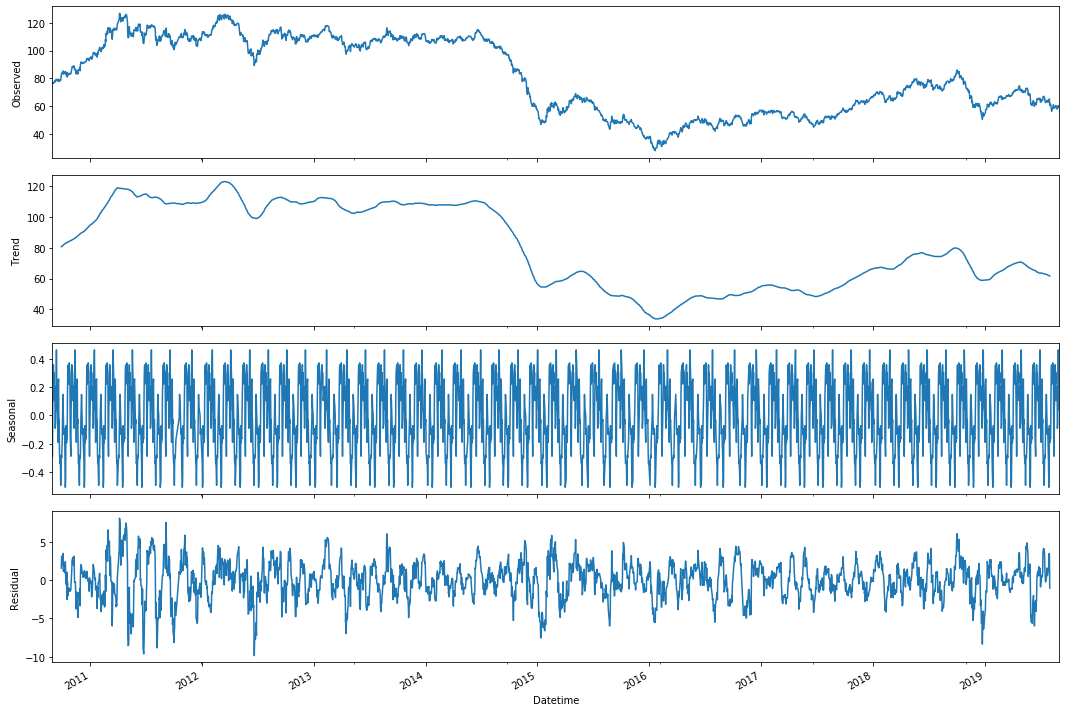

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.Value, freq=52).plot()

In [5]:
data_m = data.resample('MS').mean()
data_m.tail()

,Value
Datetime,
2019-05-01,69.966667
2019-06-01,62.980400
2019-07-01,64.292963
2019-08-01,59.263077
2019-09-01,58.840000


Критерий Дики-Фуллера: p=0.689912


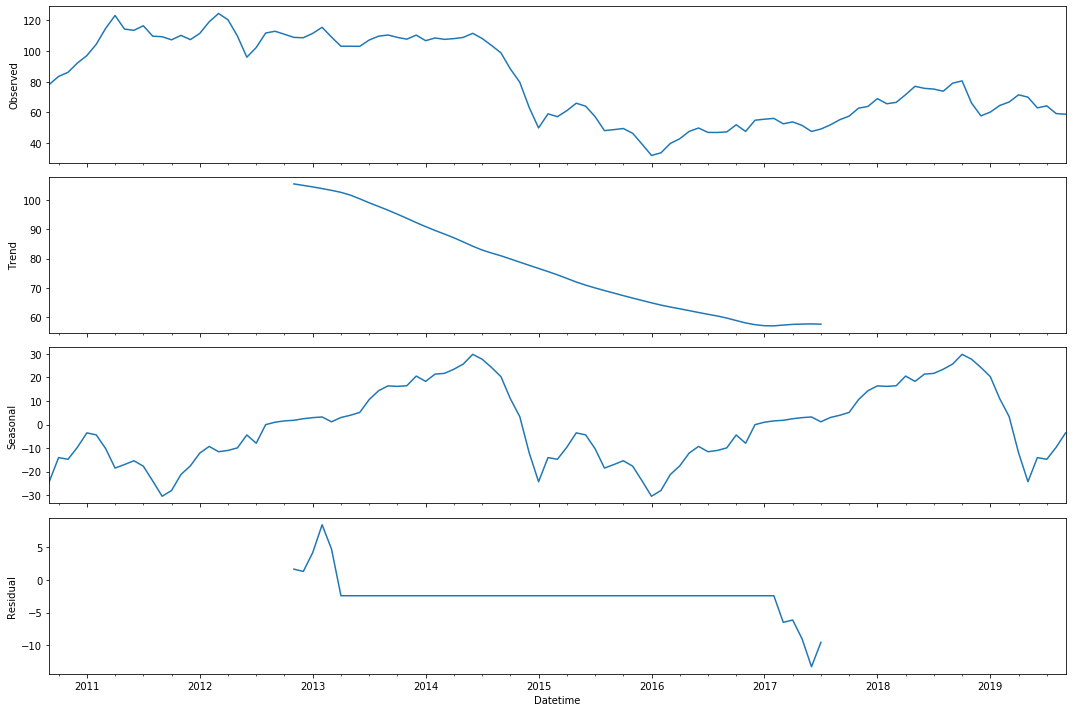

In [6]:
sm.tsa.seasonal_decompose(data_m['Value'],freq=52).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_m['Value'])[1])

Критерий Дики-Фуллера: p=0.171834


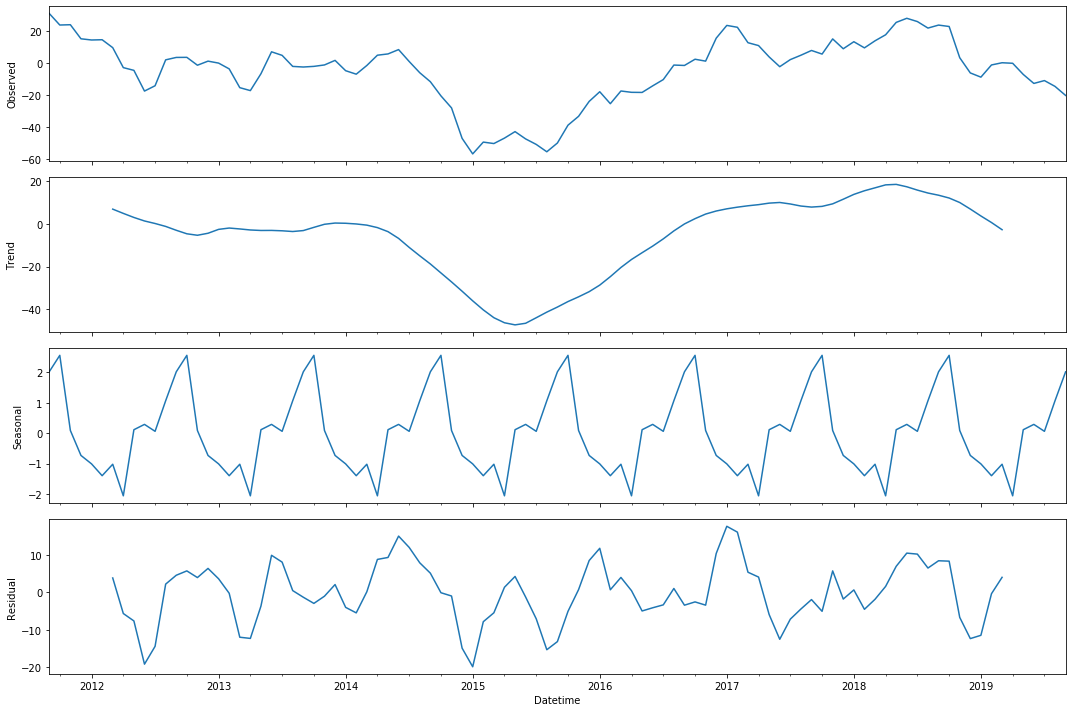

In [7]:

data_m['value_diff'] = data_m['Value'] - data_m['Value'].shift(12)
sm.tsa.seasonal_decompose(data_m['value_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_m['value_diff'][12:])[1])

отвергается гипотезу нестационарности, остатки стали лучше 
добавим ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


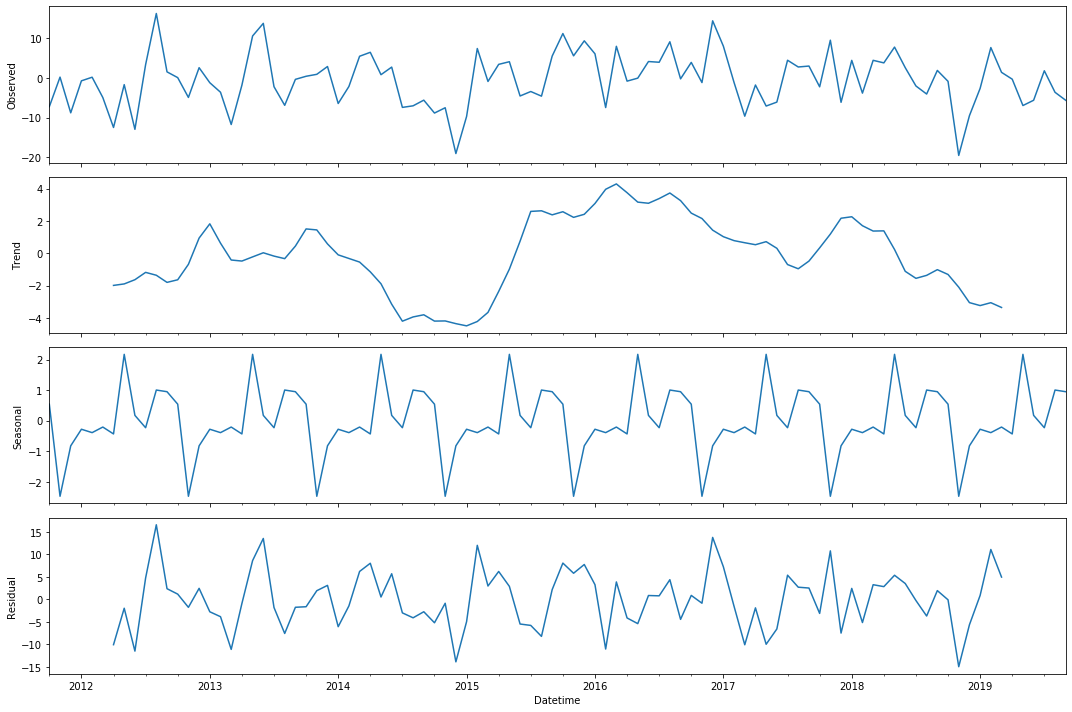

In [8]:
data_m['value_diff2'] = data_m['value_diff'] - data_m['value_diff'].shift(1)
sm.tsa.seasonal_decompose(data_m['value_diff2'][13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_m['value_diff2'][13:])[1])

Гипотеза о нестационарности отвергается, тренда нет, остатки выглядят как белый шум, также ее отвергает показатель Критерии Дики-Фуллера.
Посмотрим на Автокорреляционную функцию и Частичную автокорреляцию

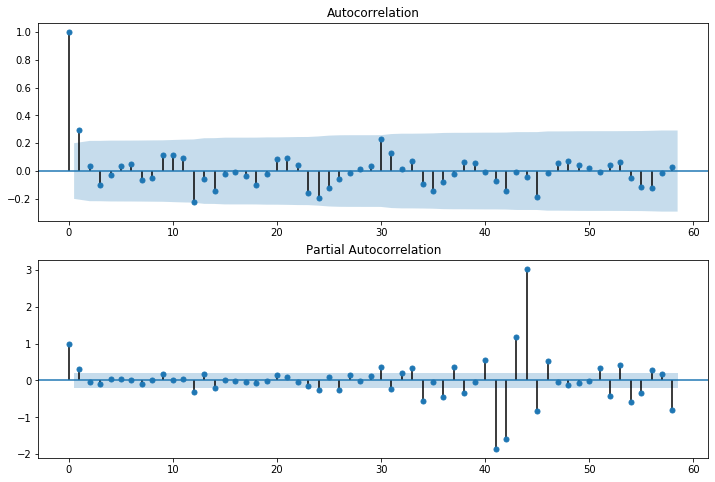

In [9]:
plt.figure(figsize=(12,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_m['value_diff2'][13:].values.squeeze(), lags=58, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_m['value_diff2'][13:].values.squeeze(), lags=58, ax=ax);

In [10]:
ps = range(0,7)
d=1
qs = range(0, 1)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

35

In [13]:
#Построим модель ARIMA
#%%time
results = []
best_aic = float("inf")



for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data_m['Value'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [14]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
8   (1, 0, 3, 0)  618.047130
9   (1, 0, 4, 0)  618.128281
13  (2, 0, 3, 0)  619.503973
14  (2, 0, 4, 0)  619.554378
7   (1, 0, 2, 0)  619.809435


In [15]:
#Посмотрим на лучшую модель:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Value   No. Observations:                  109
Model:             SARIMAX(1, 1, 0)x(3, 1, 0, 12)   Log Likelihood                -304.024
Date:                            Wed, 08 Apr 2020   AIC                            618.047
Time:                                    13:19:30   BIC                            630.869
Sample:                                09-01-2010   HQIC                           623.230
                                     - 09-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3194      0.100      3.205      0.001       0.124       0.515
ar.S.L12      -0.5091      0.133   

Критерий Стьюдента: p=0.412458
Критерий Дики-Фуллера: p=0.000000


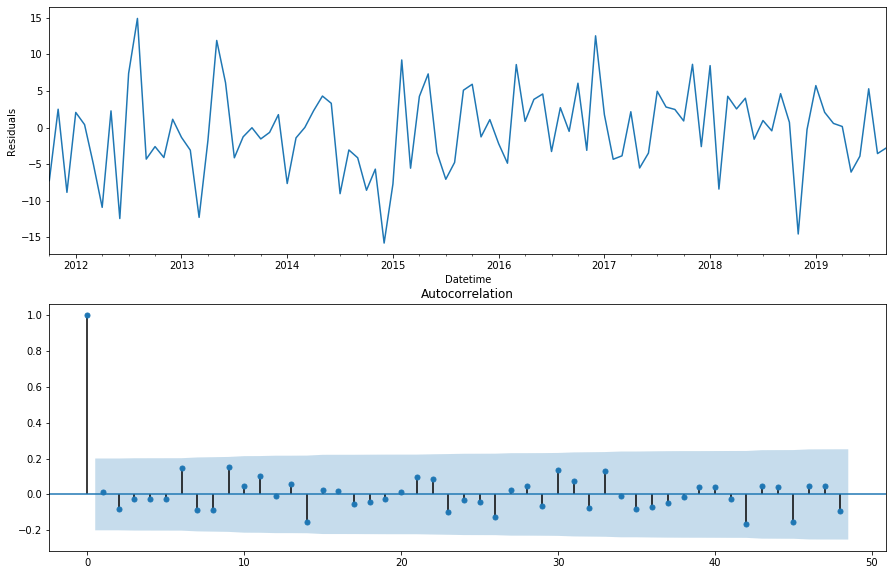

In [16]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

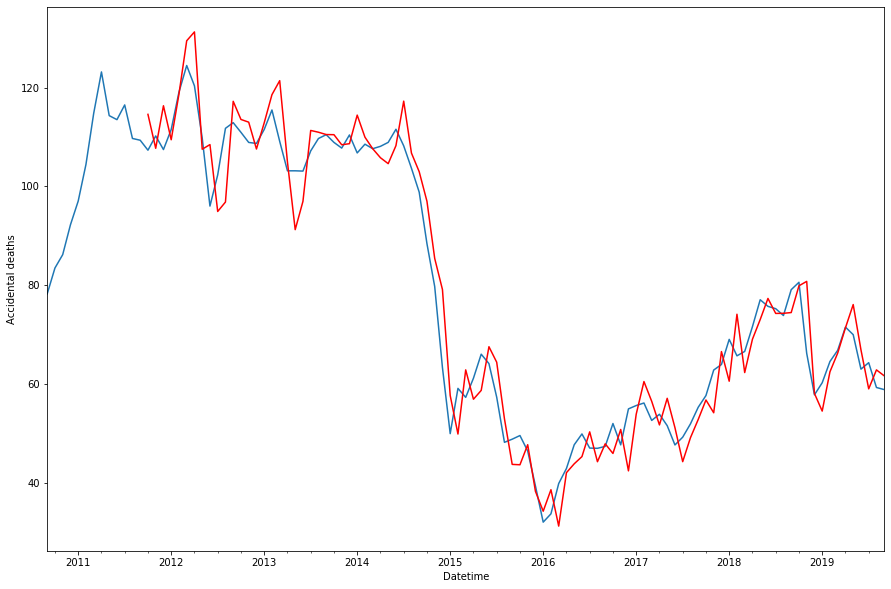

In [18]:
data_m['model'] = best_model.fittedvalues
data_m['Value'].plot()
data_m['model'][13:].plot(color='r')
plt.ylabel('Accidental deaths');

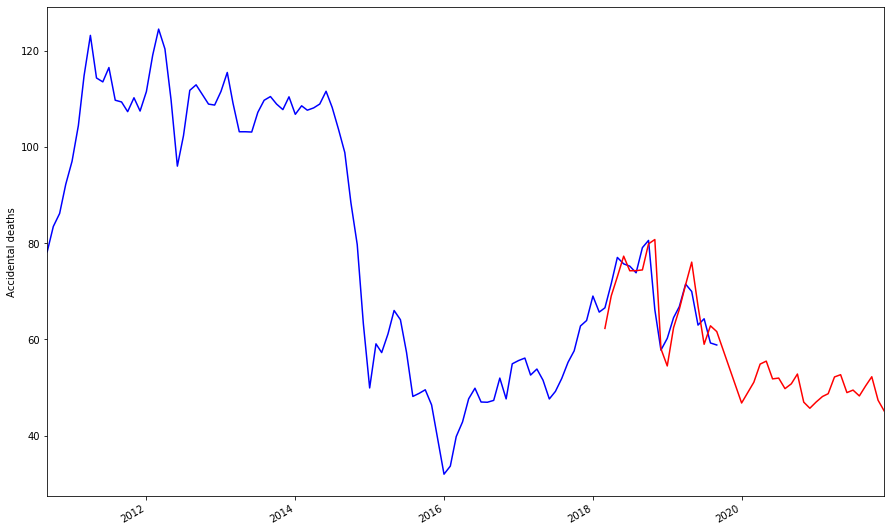

In [20]:
#прогноз
from dateutil.relativedelta import relativedelta
deaths2 = data_m[['Value']]
date_list = [pd.datetime.strptime("2020-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns=deaths2.columns)
deaths2 = pd.concat([deaths2, future])
deaths2['forecast'] = best_model.predict(start=90, end=160)

deaths2['Value'].plot(color='b')
deaths2['forecast'].plot(color='r')
plt.ylabel('Accidental deaths');